In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

In [3]:
sns.set(style="whitegrid")

In [4]:
df = pd.read_csv("creditcard.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df = df.drop(['Time'], axis=1)

X = df.drop('Class', axis=1)
y = df['Class']

In [6]:
print("Original class distribution:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts())

Original class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Resampled class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  

train_df = pd.DataFrame(X_resampled, columns=X.columns)
train_df['Class'] = y_resampled.values
train_df.to_csv('training_dataset.csv', index=False)
print("Saved: 'training_dataset.csv' with SMOTE-resampled training data")

test_df = X_test.copy()
test_df['True_Class'] = y_test.values
test_df['Predicted_Class'] = y_pred
test_df['Fraud_Probability'] = y_proba
test_df.to_csv('test_dataset.csv', index=False)
print("Saved: 'test_dataset.csv' with test predictions and fraud probability")

fraud_df = test_df[(test_df['True_Class'] == 1) | (test_df['Predicted_Class'] == 1)]
fraud_df.to_csv('fraud_cases_only.csv', index=False)
print("Saved: 'fraud_cases_only.csv' containing actual or predicted frauds only")


Saved: 'training_dataset.csv' with SMOTE-resampled training data
Saved: 'test_dataset.csv' with test predictions and fraud probability
Saved: 'fraud_cases_only.csv' containing actual or predicted frauds only



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       1.00      1.00      1.00     85294

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589

Confusion Matrix:


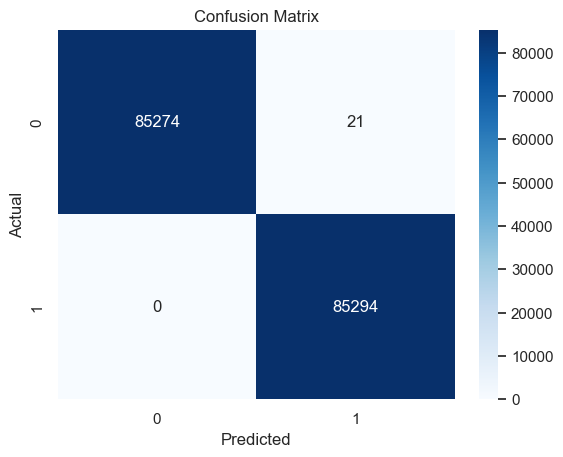

In [8]:
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

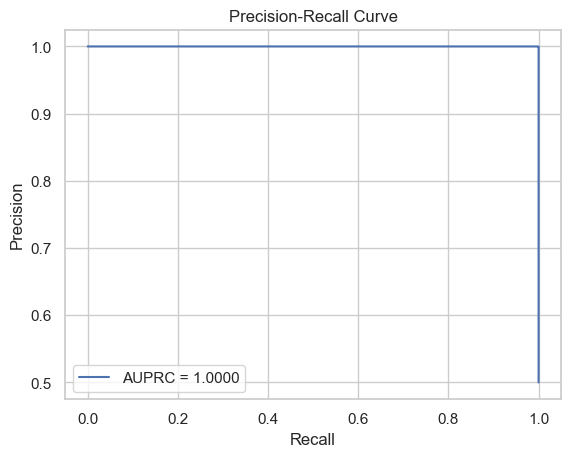

In [9]:
probs = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probs)
prc_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'AUPRC = {prc_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
df['Predicted_Class'] = model.predict(X)
df[['Amount', 'Class', 'Predicted_Class']].head(10)

,Amount,Class,Predicted_Class
0,0.244964,0,0
1,-0.342475,0,0
2,1.160686,0,0
3,0.140534,0,0
4,-0.073403,0,0
5,-0.338556,0,0
6,-0.333279,0,0
7,-0.190107,0,0
8,0.019392,0,0
9,-0.338516,0,0


In [11]:
import joblib

joblib.dump(model, 'credit_fraud_model.pkl')
print("Model saved as 'credit_fraud_model.pkl'")

Model saved as 'credit_fraud_model.pkl'


In [12]:
df['Predicted_Class'] = model.predict(X)
df['Fraud_Probability'] = model.predict_proba(X)[:, 1]
df[['Amount', 'Class', 'Predicted_Class', 'Fraud_Probability']].to_csv('all_predictions_with_probabilities.csv', index=False)
print("Saved all predictions with probabilities to 'all_predictions_with_probabilities.csv'")

Saved all predictions with probabilities to 'all_predictions_with_probabilities.csv'


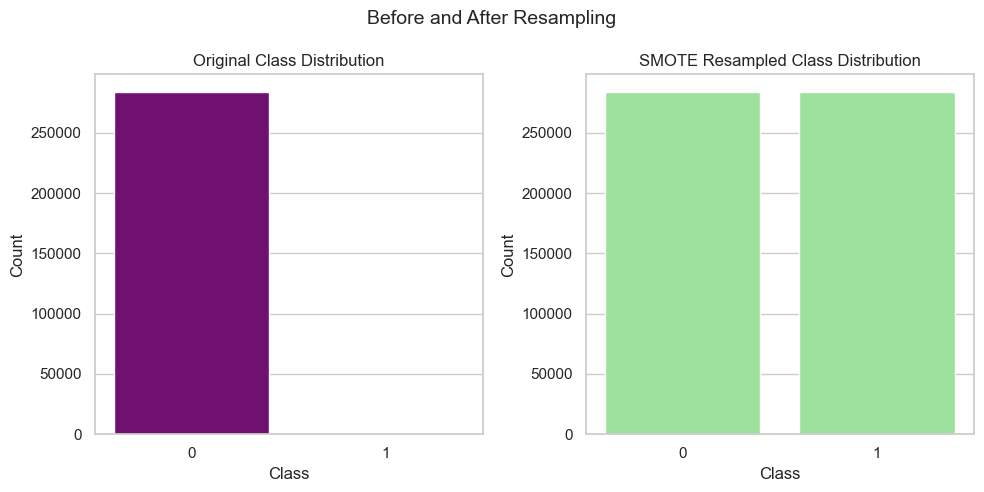

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x=y, ax=ax[0], color='purple')
ax[0].set_title('Original Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

sns.countplot(x=y_resampled, ax=ax[1], color='lightgreen')
ax[1].set_title('SMOTE Resampled Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.suptitle('Before and After Resampling', fontsize=14)
plt.tight_layout()
plt.show()

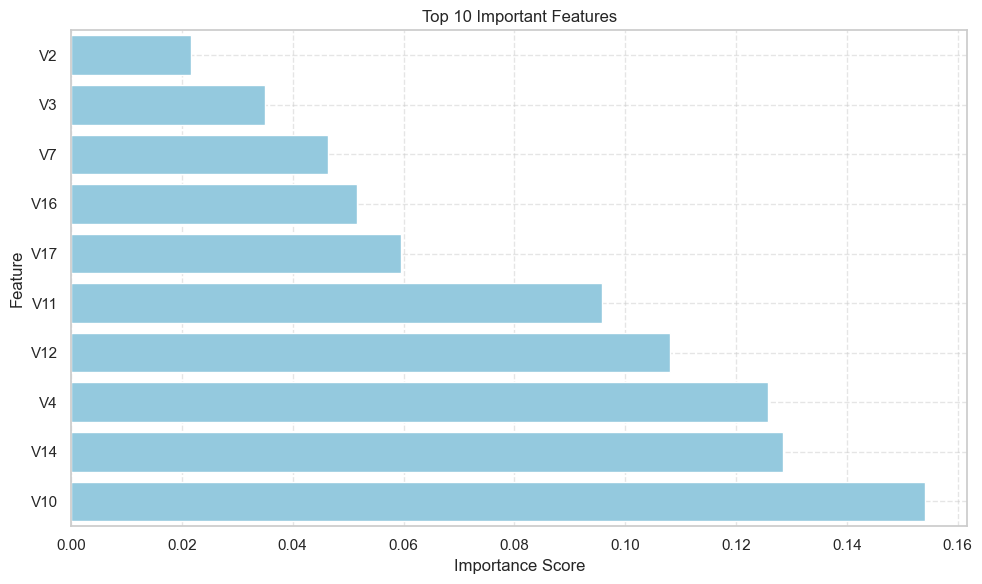

In [23]:
importances = model.feature_importances_
features = X.columns

top_idx = np.argsort(importances)[-10:]
top_features = features[top_idx]
top_importances = importances[top_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, color='skyblue')
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

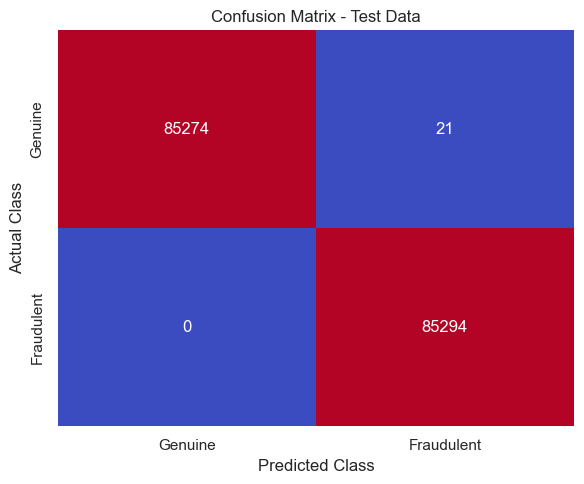

In [15]:
# Confusion matrix with annotations
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Genuine', 'Fraudulent'], yticklabels=['Genuine', 'Fraudulent'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
plt.show()

In [22]:
top_suspicious = test_df.sort_values(by='Fraud_Probability', ascending=False).head(10)
top_suspicious_display = top_suspicious[['Amount', 'True_Class', 'Predicted_Class', 'Fraud_Probability']]

print("Top 10 Most Suspicious Transactions Based on Model:")
top_suspicious_display.reset_index(drop=True, inplace=True)
top_suspicious_display

Top 10 Most Suspicious Transactions Based on Model:


,Amount,True_Class,Predicted_Class,Fraud_Probability
0,-0.352006,1,1,1.0
1,-0.349231,1,1,1.0
2,0.046539,1,1,1.0
3,0.379715,1,1,1.0
4,-0.218654,1,1,1.0
5,-0.181908,1,1,1.0
6,-0.138453,1,1,1.0
7,-0.337185,1,1,1.0
8,-0.349231,1,1,1.0
9,-0.122799,1,1,1.0
